In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_log_error
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv('sampled_tbc_training_data.csv')

count    2.000000e+03
mean     4.281221e+04
std      1.499576e+05
min      2.196000e+01
25%      1.735555e+03
50%      6.812540e+03
75%      2.440078e+04
max      3.415385e+06
Name: sales, dtype: float64


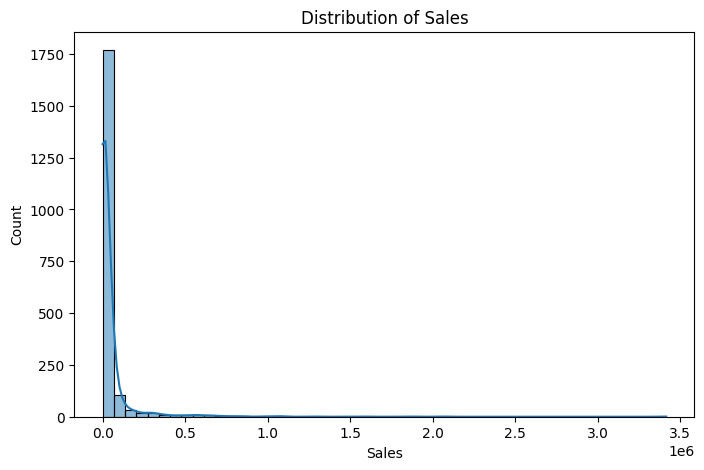

In [3]:
# Quick look at sales
print(df['sales'].describe())

# Optional: histogram to visualize distribution
plt.figure(figsize=(8,5))
sns.histplot(df['sales'], bins=50, kde=True)
plt.title('Distribution of Sales')
plt.xlabel('Sales')
plt.ylabel('Count')
plt.show()


In [5]:
# Drop leakage columns
df_reg = df.drop(columns=[col for col in df.columns if col.startswith('Sales_')])

# Select numeric features
numeric_features = ['recency', 'frequency', 'value', 'units'] + [col for col in df_reg.columns if col.startswith('Units_')]

# Select categorical features
categorical_features = ['Channel_CD','Channel_FS','Channel_NR','Channel_NUC','IsProgram','NumOfPrograms']

# Combine selected features
selected_features = numeric_features + categorical_features

# Target
target = 'sales'


In [10]:
df[numeric_features].describe()

,recency,frequency,value,units,Units_BLT,Units_FRM,Units_IND,Units_MBT,Units_MRT,Units_OTR,...,Units_HIFLY,Units_PROVATO,Units_ARMADILLO,Units_FUZION,Units_EUROGRIP,Units_is_win_NO,Units_is_win_YES,Units_is_ev_-,Units_is_ev_NO,Units_is_ev_YES
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.0,2000.0,2000.0,2000.0,2000.0,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,48.858000,87.221000,480.995590,280.374474,0.393928,1.503271,0.775262,0.132505,12.606162,0.137000,...,0.0,0.0,0.0,0.0,0.0,279.382856,0.987118,216.623579,63.706896,0.044000
std,85.829244,278.567101,575.517781,1119.791115,2.815687,8.566144,5.050475,0.974669,63.324135,1.272808,...,0.0,0.0,0.0,0.0,0.0,1118.600857,6.483989,942.619689,243.481080,0.539638
min,1.000000,1.000000,21.960000,0.038593,0.000000,0.000000,0.000000,0.000000,-7.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,4.750000,275.485630,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,12.000000,0.000000,10.000000,0.000000,0.000000
50%,12.000000,17.000000,384.518418,48.749337,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,48.000000,0.000000,37.000000,8.000000,0.000000
75%,49.000000,60.000000,530.049583,173.129705,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,172.250000,0.000000,134.250000,34.000000,0.000000
max,561.000000,7240.000000,13579.500000,34485.496354,57.000000,154.000000,97.000000,18.000000,1016.000000,26.000000,...,0.0,0.0,0.0,0.0,0.0,34485.496354,112.307617,31464.513503,6381.788927,18.000000


In [6]:
# Create log-transformed target
df['sales_log'] = np.log1p(df['sales'])  # log1p handles zero values safely


In [8]:
df_reg = df.drop(columns=[col for col in df.columns if col.startswith('Sales_')] + ['Customer_ID'])


In [9]:
# Correlation with target
corr_target = df_reg.corr()['sales_log'].sort_values(ascending=False)
print(corr_target.head(20))  # top 20 correlated features
print(corr_target.tail(20))  # bottom 20


sales_log              1.000000
frequency              0.520819
sales                  0.517304
Units                  0.503215
Units_MICHELIN         0.475919
Units_is_ev_NO         0.460950
units                  0.444965
Units_is_win_NO        0.444203
Units_RLT              0.432515
Units_PSUV             0.431982
age                    0.428822
Units_HANKOOK          0.422924
Units_is_ev_-          0.409430
Units_National Acct    0.399457
Units_NITTO            0.386879
Units_BFGOODRICH       0.386684
Units_PIRELLI          0.350455
IsProgram              0.349759
Units_PASS             0.337453
Units_TOYO             0.322800
Name: sales_log, dtype: float64
Units_GREENBALL     NaN
Units_LINGLONG      NaN
Units_RIKEN         NaN
Units_COUNTRYWIDE   NaN
Units_KLEBER        NaN
Units_TEMPRA        NaN
Units_DUNLOP        NaN
Units_SIGMA         NaN
Units_SPECIALTY     NaN
Units_DYNACARGO     NaN
Units_BIG O         NaN
Units_DENMAN        NaN
Units_HIFLY         NaN
Units_PROVATO   

In [11]:
skewed_features = ['recency', 'frequency', 'value', 'units']

for col in skewed_features:
    df[f'{col}_log'] = np.log1p(df[col])


In [12]:
features = [
    'recency_log', 'frequency_log', 'value_log', 'units_log',
    'Channel_CD', 'Channel_FS', 'Channel_NR', 'Channel_NUC',
    'IsProgram', 'NumOfPrograms',
    'Units_is_win_NO', 'Units_is_win_YES',
    'Units_is_ev_NO', 'Units_is_ev_-', 'Units_is_ev_YES',
    'Units_MICHELIN', 'Units_PSUV', 'Units_RLT', 'Units_HANKOOK',
    'Units_National Acct', 'Units_BFGOODRICH', 'Units_PIRELLI',
    'Units_PASS', 'Units_TOYO'
]


In [13]:
target = 'sales_log'


In [14]:
from sklearn.model_selection import train_test_split

# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    df[features],
    df[target],
    test_size=0.2,
    random_state=42
)

print("Training samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])


Training samples: 1600
Test samples: 400


In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize model
lr = LinearRegression()

# Fit on training data
lr.fit(X_train, y_train)

# Predict on test set
y_pred = lr.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)


Mean Squared Error (MSE): 0.04951709322612984
R-squared (R2): 0.9877641621983122


In [16]:
# Create a dataframe with feature names and coefficients
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': lr.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(coef_df)


                Feature  Coefficient
1         frequency_log     1.040365
2             value_log     0.985139
8             IsProgram    -0.098660
3             units_log     0.082270
9         NumOfPrograms     0.029301
7           Channel_NUC    -0.022091
4            Channel_CD     0.017466
5            Channel_FS     0.010560
14      Units_is_ev_YES     0.010280
0           recency_log    -0.009043
6            Channel_NR    -0.005935
11     Units_is_win_YES    -0.005306
10      Units_is_win_NO    -0.004252
12       Units_is_ev_NO     0.004185
13        Units_is_ev_-     0.004081
23           Units_TOYO    -0.000779
21        Units_PIRELLI    -0.000571
17            Units_RLT     0.000297
20     Units_BFGOODRICH    -0.000169
18        Units_HANKOOK    -0.000156
22           Units_PASS     0.000062
15       Units_MICHELIN    -0.000039
19  Units_National Acct     0.000024
16           Units_PSUV    -0.000004


In [17]:
top_features = [
    'frequency_log',
    'value_log',
    'units_log',
    'IsProgram',
    'NumOfPrograms',
    'Channel_NUC',
    'Channel_CD'
]


In [18]:
# Split train/test again using only top features
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# Initialize and fit model
lr_top = LinearRegression()
lr_top.fit(X_train_top, y_train)

# Predict
y_pred_top = lr_top.predict(X_test_top)

# Evaluate
mse_top = mean_squared_error(y_test, y_pred_top)
r2_top = r2_score(y_test, y_pred_top)

print("Top Features MSE:", mse_top)
print("Top Features R2:", r2_top)

# Coefficients
coef_top_df = pd.DataFrame({
    'Feature': top_features,
    'Coefficient': lr_top.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(coef_top_df)


Top Features MSE: 0.016781828735926166
Top Features R2: 0.9958531545159411
         Feature  Coefficient
0  frequency_log     1.001278
1      value_log     0.968015
2      units_log     0.096028
5    Channel_NUC    -0.062092
4  NumOfPrograms    -0.040954
6     Channel_CD     0.012619
3      IsProgram    -0.004723


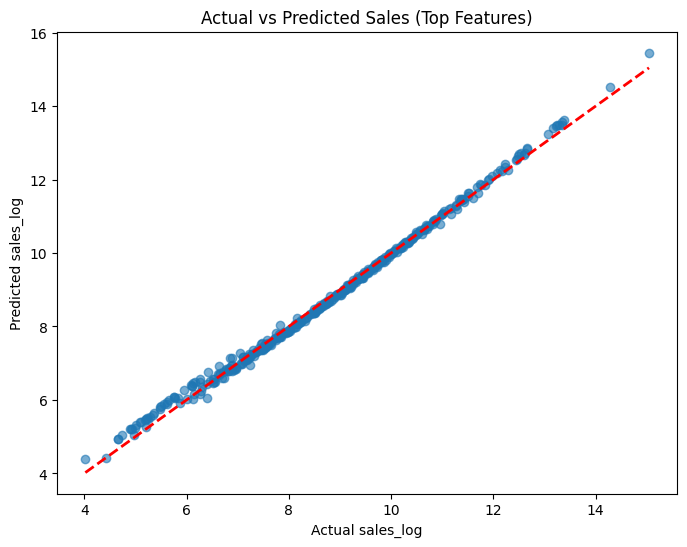

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_top, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual sales_log")
plt.ylabel("Predicted sales_log")
plt.title("Actual vs Predicted Sales (Top Features)")
plt.show()


In [20]:
y_train_pred = lr_top.predict(X_train_top)

mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

print("Train MSE:", mse_train)
print("Train R2:", r2_train)


Train MSE: 0.015220720237732887
Train R2: 0.995833124488573


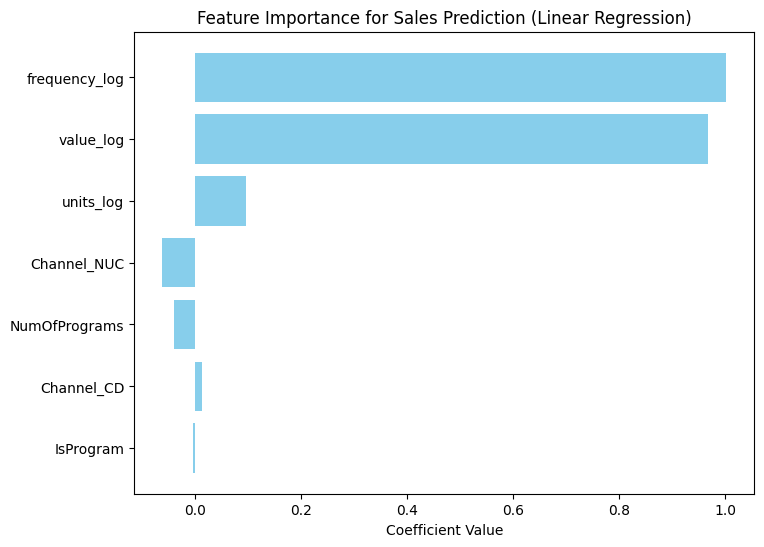

In [21]:
import matplotlib.pyplot as plt

# Sort features by absolute coefficient
coef_df_sorted = coef_top_df.copy()
coef_df_sorted['abs_coef'] = coef_df_sorted['Coefficient'].abs()
coef_df_sorted = coef_df_sorted.sort_values(by='abs_coef', ascending=True)

# Plot horizontal bar chart
plt.figure(figsize=(8,6))
plt.barh(coef_df_sorted['Feature'], coef_df_sorted['Coefficient'], color='skyblue')
plt.xlabel("Coefficient Value")
plt.title("Feature Importance for Sales Prediction (Linear Regression)")
plt.show()


In [22]:
# Predict on test set
y_pred_test = lr_top.predict(X_test_top)

# Residuals
residuals = y_test - y_pred_test


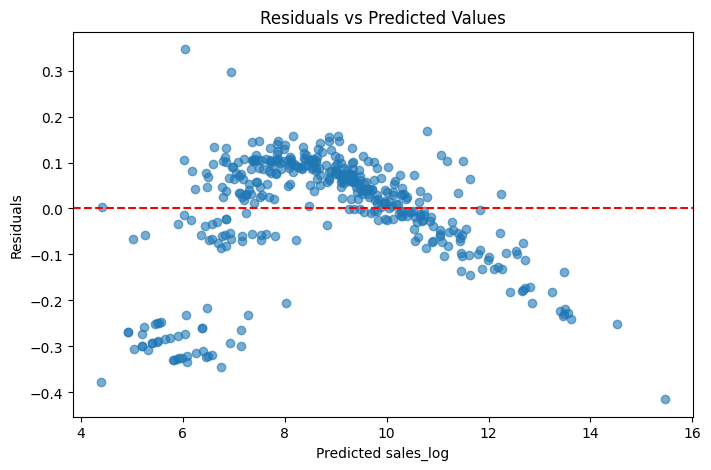

In [23]:
plt.figure(figsize=(8,5))
plt.scatter(y_pred_test, residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted sales_log")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()


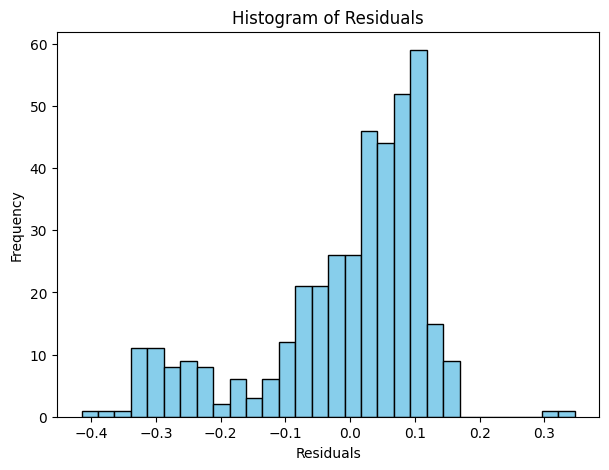

In [24]:
plt.figure(figsize=(7,5))
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()


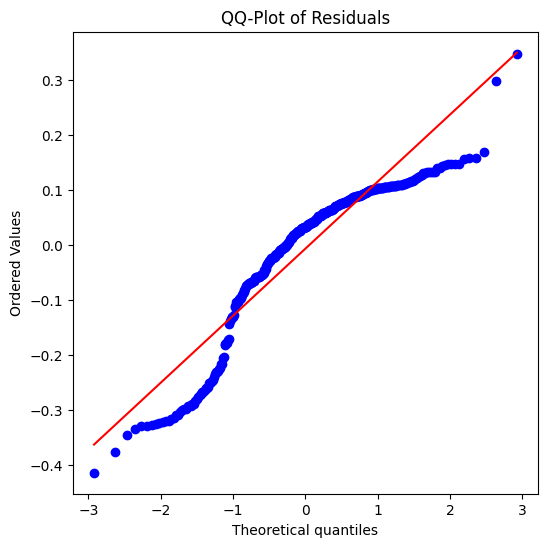

In [25]:
import scipy.stats as stats

plt.figure(figsize=(6,6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ-Plot of Residuals")
plt.show()


In [26]:
# Top 25 features for sales prediction
top_features = [
    'recency_log', 'frequency_log', 'value_log', 'units_log',
    'Channel_CD', 'Channel_FS', 'Channel_NR', 'Channel_NUC',
    'IsProgram', 'NumOfPrograms',
    'Units_MICHELIN', 'Units_PSUV', 'Units_RLT', 'Units_HANKOOK',
    'Units_NITTO', 'Units_BFGOODRICH', 'Units_PIRELLI', 'Units_PASS',
    'Units_TOYO', 'Units_COOPER', 'Units_is_ev_NO', 'Units_is_ev_YES',
    'Units_is_ev_-', 'Units_is_win_NO', 'Units_is_win_YES'
]

X_top = df[top_features]
y = df['sales_log']


In [27]:
# Detect extreme outliers in X_top and y
outlier_idx = set()

for col in X_top.select_dtypes(include=[np.number]).columns:
    Q1 = X_top[col].quantile(0.25)
    Q3 = X_top[col].quantile(0.75)
    IQR = Q3 - Q1
    # indices of extreme outliers
    idx = X_top[(X_top[col] < Q1 - 3*IQR) | (X_top[col] > Q3 + 3*IQR)].index
    outlier_idx.update(idx)

# Also check target variable
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1
idx = y[(y < Q1 - 3*IQR) | (y > Q3 + 3*IQR)].index
outlier_idx.update(idx)

print(f"Total extreme outliers detected: {len(outlier_idx)}")


Total extreme outliers detected: 1110


In [29]:
# Cap numeric features
for col in X_top.select_dtypes(include=[np.number]).columns:
    lower = X_top[col].quantile(0.01)
    upper = X_top[col].quantile(0.99)
    X_top[col] = np.clip(X_top[col], lower, upper)

# Cap target variable
lower = y.quantile(0.01)
upper = y.quantile(0.99)
y = np.clip(y, lower, upper)


/tmp/ipython-input-2568748447.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_top[col] = np.clip(X_top[col], lower, upper)
/tmp/ipython-input-2568748447.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_top[col] = np.clip(X_top[col], lower, upper)
/tmp/ipython-input-2568748447.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_top, y, test_size=0.2, random_state=42
)

# Train Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions
y_pred = lr.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse}")
print(f"Test R2: {r2}")

# Feature coefficients
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(coefficients)


Test MSE: 0.013178597286035279
Test R2: 0.9966586422770534
             Feature   Coefficient
2          value_log  9.690447e-01
1      frequency_log  9.374601e-01
3          units_log  1.869061e-01
8          IsProgram -9.348014e-02
9      NumOfPrograms  3.949973e-02
4         Channel_CD -1.443777e-02
6         Channel_NR -1.141173e-02
5         Channel_FS -1.058568e-02
21   Units_is_ev_YES -3.133472e-03
0        recency_log -2.775989e-03
24  Units_is_win_YES -9.285742e-04
18        Units_TOYO -6.930817e-04
14       Units_NITTO  4.517400e-04
15  Units_BFGOODRICH -4.385760e-04
16     Units_PIRELLI -4.088401e-04
13     Units_HANKOOK -2.882870e-04
19      Units_COOPER -2.686204e-04
12         Units_RLT  2.185411e-04
23   Units_is_win_NO -1.445956e-04
20    Units_is_ev_NO  8.775739e-05
11        Units_PSUV  7.731740e-05
22     Units_is_ev_- -4.462210e-05
10    Units_MICHELIN  3.380963e-05
17        Units_PASS -2.454491e-05
7        Channel_NUC  4.107825e-15


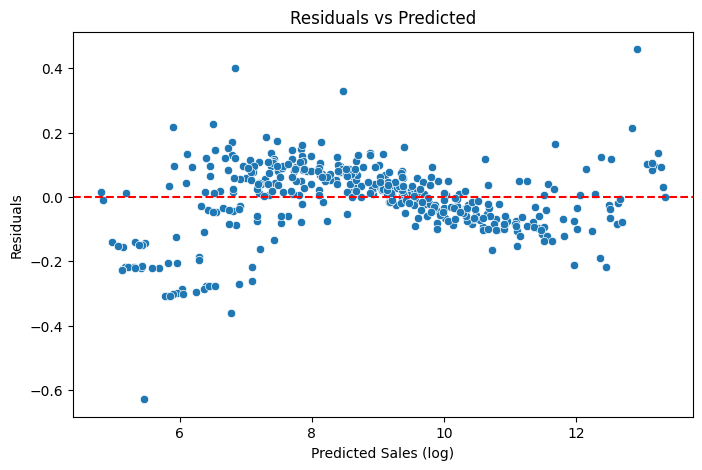

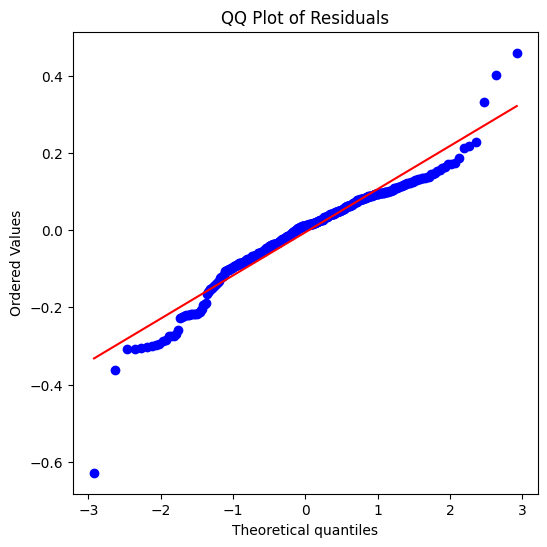

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Residuals
residuals = y_test - y_pred

# Residual plot
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Sales (log)")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()

# QQ plot
plt.figure(figsize=(6,6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")
plt.show()


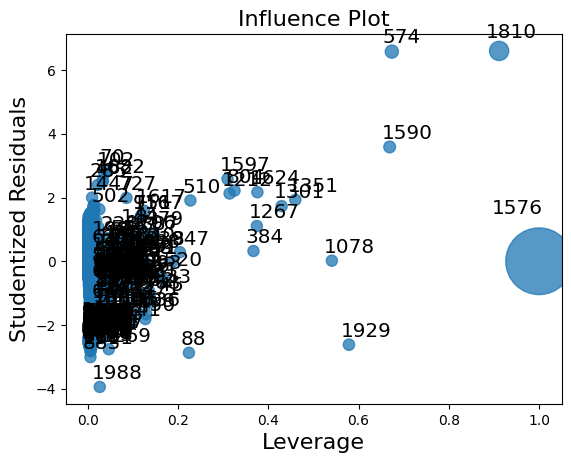

In [33]:
import statsmodels.api as sm

X = df[top_features]  # your top features
y = df['sales_log']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
sm.graphics.influence_plot(model)
plt.show()


In [34]:
from sklearn.model_selection import train_test_split

X = df[top_features]  # use the same 25 features you used in linear regression
y = df['sales_log']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize model
rf = RandomForestRegressor(random_state=42)

# Fit model
rf.fit(X_train, y_train)

# Predict on train and test sets
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Evaluate performance
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Train MSE:", train_mse)
print("Train R2:", train_r2)
print("Test MSE:", test_mse)
print("Test R2:", test_r2)


Train MSE: 0.0049735172396278724
Train R2: 0.9986384332102702
Test MSE: 0.03476889683232521
Test R2: 0.9914084903925772


In [36]:
import pandas as pd

# Get feature importances
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances)


             Feature  Importance
3          units_log    0.634529
23   Units_is_win_NO    0.273762
2          value_log    0.040306
22     Units_is_ev_-    0.027080
1      frequency_log    0.015123
10    Units_MICHELIN    0.002757
11        Units_PSUV    0.001485
17        Units_PASS    0.000887
12         Units_RLT    0.000825
0        recency_log    0.000697
15  Units_BFGOODRICH    0.000661
20    Units_is_ev_NO    0.000389
16     Units_PIRELLI    0.000243
19      Units_COOPER    0.000224
14       Units_NITTO    0.000215
18        Units_TOYO    0.000198
13     Units_HANKOOK    0.000190
9      NumOfPrograms    0.000103
8          IsProgram    0.000102
24  Units_is_win_YES    0.000071
5         Channel_FS    0.000060
6         Channel_NR    0.000043
4         Channel_CD    0.000039
21   Units_is_ev_YES    0.000008
7        Channel_NUC    0.000002


In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Initialize the model
rf = RandomForestRegressor(random_state=42)

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}


In [38]:
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='r2',  # we want to maximize R²
    n_jobs=-1,     # use all cores
    verbose=2
)


In [39]:
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
244 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py"

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='r2', verbose=2)

In [41]:
# Get the best estimator
best_rf = grid_search.best_estimator_

# Predictions on train and test
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

# Metrics
from sklearn.metrics import mean_squared_error, r2_score

# Train metrics
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Test metrics
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Train MSE: {train_mse}, Train R2: {train_r2}")
print(f"Test MSE: {test_mse}, Test R2: {test_r2}")


Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Train MSE: 0.007993154008922981, Train R2: 0.9978117673028194
Test MSE: 0.070514847453563, Test R2: 0.9825755475566312


In [42]:
import pandas as pd

feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances)


             Feature  Importance
23   Units_is_win_NO    0.214870
3          units_log    0.204378
22     Units_is_ev_-    0.143512
1      frequency_log    0.112961
20    Units_is_ev_NO    0.068753
11        Units_PSUV    0.065470
12         Units_RLT    0.036857
10    Units_MICHELIN    0.036357
17        Units_PASS    0.033744
2          value_log    0.027980
15  Units_BFGOODRICH    0.020312
0        recency_log    0.009228
19      Units_COOPER    0.008097
13     Units_HANKOOK    0.006486
14       Units_NITTO    0.004552
18        Units_TOYO    0.002346
16     Units_PIRELLI    0.001574
9      NumOfPrograms    0.000612
8          IsProgram    0.000581
5         Channel_FS    0.000407
6         Channel_NR    0.000363
4         Channel_CD    0.000284
24  Units_is_win_YES    0.000245
21   Units_is_ev_YES    0.000018
7        Channel_NUC    0.000014
